In [27]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
import torchvision.transforms as T
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.controller.recorder import TrainRecorder
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.image_generation.controllers.trainer_gan import GANTrainer
from torchlake.image_generation.models.dcgan import (DCGANDiscriminator,
                                                     DCGANGenerator)
from tqdm import tqdm

# Setting

In [28]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

In [29]:
artifact_path = Path('../../artifacts/dcgan')
artifact_path.mkdir(exist_ok=True)

data_path = Path('../../data/mnist')

In [30]:
DEVICE = torch.device('cuda:0')

# Data

In [31]:
preprocess = T.Compose(
    [
        T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        T.ToTensor(),
        lambda x: 2 * x - 1,
    ]
)

In [32]:
train_data = torchvision.datasets.MNIST(
    root=data_path.as_posix(),
    train=True,
    transform=preprocess,
)

test_data = torchvision.datasets.MNIST(
    root=data_path.as_posix(),
    train=True,
    transform=preprocess,
)

In [33]:
for img, _ in train_data:
    print(img.shape)
    break

torch.Size([1, 32, 32])


In [34]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

test_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
)

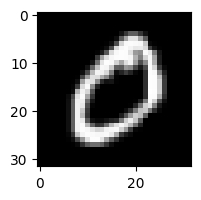

In [35]:
# 資料集繪圖
plt.figure(figsize=(2, 2))
plt.imshow(img_tensor_to_np((train_data[1][0] + 1) / 2), cmap='gray')

# model

In [36]:
LATENT_DIM = 128
HIDDEN_DIM = 1024
NUM_BLOCK = 4

In [37]:
# 2 x 16 = 32
generator = DCGANGenerator(LATENT_DIM, 1, HIDDEN_DIM, num_block=NUM_BLOCK, init_shape=(2, 2)).to(DEVICE)
# 32 / 32 = 1
discriminator = DCGANDiscriminator(1, HIDDEN_DIM // (2**NUM_BLOCK), image_shape=(IMAGE_SIZE, IMAGE_SIZE), num_block=NUM_BLOCK).to(DEVICE)

In [38]:
torchinfo.summary(generator)

Layer (type:depth-idx)                   Param #
DCGANGenerator                           --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       528,384
│    └─Unflatten: 2-2                    --
│    └─BatchNorm2d: 2-3                  2,048
├─Sequential: 1-2                        --
│    └─ConvBNReLU: 2-4                   --
│    │    └─ConvTranspose2d: 3-1         8,388,608
│    │    └─BatchNorm2d: 3-2             1,024
│    │    └─ReLU: 3-3                    --
│    └─ConvBNReLU: 2-5                   --
│    │    └─ConvTranspose2d: 3-4         2,097,152
│    │    └─BatchNorm2d: 3-5             512
│    │    └─ReLU: 3-6                    --
│    └─ConvBNReLU: 2-6                   --
│    │    └─ConvTranspose2d: 3-7         524,288
│    │    └─BatchNorm2d: 3-8             256
│    │    └─ReLU: 3-9                    --
│    └─ConvBNReLU: 2-7                   --
│    │    └─ConvTranspose2d: 3-10        131,072
│    │    └─BatchNorm2d: 3-11     

In [39]:
generator

DCGANGenerator(
  (foot): Sequential(
    (0): Linear(in_features=128, out_features=4096, bias=True)
    (1): Unflatten(dim=-1, unflattened_size=(1024, 2, 2))
    (2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (blocks): Sequential(
    (0): ConvBNReLU(
      (conv): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (1): ConvBNReLU(
      (conv): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (2): ConvBNReLU(
      (conv): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [40]:
torchinfo.summary(discriminator)

Layer (type:depth-idx)                   Param #
DCGANDiscriminator                       --
├─Sequential: 1-1                        --
│    └─Conv2dNormActivation: 2-1         --
│    │    └─Conv2d: 3-1                  640
│    │    └─LeakyReLU: 3-2               --
├─Sequential: 1-2                        --
│    └─Conv2dNormActivation: 2-2         --
│    │    └─Conv2d: 3-3                  73,728
│    │    └─BatchNorm2d: 3-4             256
│    │    └─LeakyReLU: 3-5               --
│    └─Conv2dNormActivation: 2-3         --
│    │    └─Conv2d: 3-6                  294,912
│    │    └─BatchNorm2d: 3-7             512
│    │    └─LeakyReLU: 3-8               --
│    └─Conv2dNormActivation: 2-4         --
│    │    └─Conv2d: 3-9                  1,179,648
│    │    └─BatchNorm2d: 3-10            1,024
│    │    └─LeakyReLU: 3-11              --
│    └─Conv2dNormActivation: 2-5         --
│    │    └─Conv2d: 3-12                 4,718,592
│    │    └─BatchNorm2d: 3-13            2

In [41]:
discriminator

DCGANDiscriminator(
  (foot): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (blocks): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Conv2dNormActivation(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)


# train

In [42]:
EPOCH = 5

In [43]:
trainer = GANTrainer(EPOCH, DEVICE)
# trainer.set_discriminator_cycle(2)

In [44]:
recorder = TrainRecorder(total_epoch=EPOCH, num_loss=2, loss_names=["discriminator", "generator"])
recorder.increment_data_size(len(train_data))

In [45]:
LR = 1e-4
BETA = (0.5, 0.999)

In [ ]:
criterion = nn.BCEWithLogitsLoss(reduction="mean")
optim_G = torch.optim.Adam(generator.parameters(), lr=LR , betas=BETA)
optim_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=BETA)

In [47]:
from typing import Generator

from torchlake.common.utils.random import generate_normal

def noise_generator(batch_size: int) -> Generator[torch.Tensor, None, None]:
    yield generate_normal(batch_size, LATENT_DIM).to(DEVICE)

In [48]:
training_losses = trainer.run(
    train_loader,
    noise_generator,
    generator,
    discriminator,
    optim_G,
    optim_D,
    criterion,
    criterion,
    recorder=recorder,
)

Enable AMP: False


100%|██████████| 937/937 [00:54<00:00, 17.11it/s]


------------------------------------
Epoch 1
------------------------------------
discriminator: 4.2996e-01 (0.00%)
generator: 1.2818e+00 (0.00%)


100%|██████████| 937/937 [00:55<00:00, 17.00it/s]


------------------------------------
Epoch 2
------------------------------------
discriminator: 8.2523e-01 (92.00%)
generator: 2.7880e+00 (118.00%)


100%|██████████| 937/937 [00:55<00:00, 16.91it/s]


------------------------------------
Epoch 3
------------------------------------
discriminator: 1.1428e+00 (38.00%)
generator: 4.6896e+00 (68.00%)


100%|██████████| 937/937 [00:57<00:00, 16.36it/s]


------------------------------------
Epoch 4
------------------------------------
discriminator: 1.3519e+00 (18.00%)
generator: 7.2597e+00 (55.00%)


100%|██████████| 937/937 [00:55<00:00, 16.81it/s]

------------------------------------
Epoch 5
------------------------------------
discriminator: 1.5141e+00 (12.00%)
generator: 1.0328e+01 (42.00%)


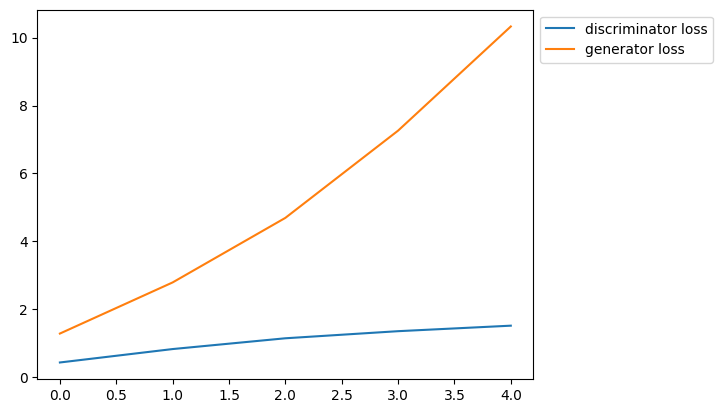

In [49]:
plt.plot(training_losses[0], label="discriminator loss")
plt.plot(training_losses[1], label="generator loss")
plt.legend(bbox_to_anchor=(1, 1))

# evaluation

In [50]:
TEST_BATCH_SIZE = 9

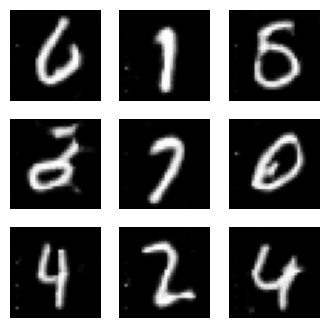

In [26]:
# 合成圖片
generator.eval()
with torch.no_grad():
    noise = generate_normal(TEST_BATCH_SIZE, LATENT_DIM).to(DEVICE)
    gen_img = (generator(noise) + 1) / 2
    
plot_grids(
    img_tensor_to_np(gen_img),
    num_row=3,
    num_col=3,
    figsize=(4,4),
    cmap='gray',
)

In [ ]:
# 區別是否為真實圖片
generator.eval()
discriminator.eval()
with torch.no_grad():
    hits = 0.0
    for img, _ in tqdm(test_loader):
        img = img.to(DEVICE)
        hits += discriminator(img).sigmoid().gt(0.5).sum().item()

    print(hits / len(train_data))

In [ ]:
# 區別是否為合成圖片
generator.eval()
discriminator.eval()
with torch.no_grad():
    hits = 0.0
    for img, _ in tqdm(test_loader):
        noise = torch.randn(BATCH_SIZE, LATENT_DIM).to(DEVICE)
        gen_img = generator(noise)
        hits += discriminator(gen_img).sigmoid().gt(0.5).sum().item()
    print(hits / len(train_data))

100%|██████████| 938/938 [00:24<00:00, 38.98it/s]

1.0005333333333333


In [ ]:
generator_path = artifact_path / 'dcgan.generator.pth'

In [ ]:
torch.save(generator.state_dict(), generator_path.as_posix())

In [ ]:
generator.load_state_dict(torch.load(generator_path.as_posix()))

<All keys matched successfully>